# Transfer Learning Using VGG16 and Data Augmentation

See if the Stanford dataset did a better job training the classifer.

## Import libraries

In [86]:
import cv2
from datetime import datetime
from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from random import choice, randint
from shutil import copyfile, rmtree
from sklearn.datasets import load_files 
from sklearn.metrics import accuracy_score

from keras.utils import np_utils
from tensorflow import device
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.callbacks import ModelCheckpoint
from tensorflow import config
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [87]:
# Check and make sure the gpu is available
config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [88]:
# Force keras to run on the gpu
with device("/GPU:0"):
   print("tf.keras code in this scope will run on GPU")

tf.keras code in this scope will run on GPU


## Stanford Dataset EDA

Lets look at another dataset from http://vision.stanford.edu/aditya86/ImageNetDogs/

In [148]:
def count_files_in_folders(path, sep):
    """Creates a dataframe of the folder with file counts in that folder
    
    input: path(str) - the file path of the directory that you want to count the subfolders in
           sep(str) -  the seperator that is used to break apart the folder name
    output: folder_counts_df(df) -  that has the following columns:
                       folder_number (int), breed (str), len_files (int)
    """
    # Change the working directory
    os.chdir(path)

    result_list = []
    path, dirs, files = next(os.walk("."))
    for dir_ in dirs:

        # Split the folder name into a folder number and a breed
        folder_number, breed = dir_.split(sep, 1)

        # Get the number of files in the directory
        files_ = glob(dir_ + r"\*.*")
        len_files = (len(files_))

        # Create a dictionary of values
        result_dict = {'folder_name': dir_,
                       'folder_number': folder_number,
                       'breed': breed,
                       'len_files': len_files}

        # Append to a list
        result_list.append(result_dict)

    # Create the df
    dog_folder_counts_df = pd.DataFrame(result_list)

    # Sort
    dog_folder_counts_df.sort_values(by = ['len_files'], inplace = True)
    
    return dog_folder_counts_df


In [149]:
def plot_folder_counts(folder_counts_df):
    """Horizontally bar plots the folder counts"""
    
    y_pos = np.arange(folder_counts_df.shape[0])
    plt.figure(figsize = (12, 24))
    plt.title('Folder Counts By Dog Breed')
    plt.ylim(min(y_pos)-1, max(y_pos)+1)
    plt.barh('breed', 'len_files', data = dog_folder_counts_df)
    path = r'D:\OneDrive\Data Science\udacity\dsnd\P5 - Capstone\images'
    plt.savefig(path + r'\folders_count.png', dpi=300, bbox_inches='tight')
    plt.show();
    

In [150]:
# Setup the path and the seperator
path = r'D:\large_files\DSND_Capstone\data\stanford\images'
sep = '-'

# Call the function to count the files
dog_folder_counts_df = count_files_in_folders(path, sep)
dog_folder_counts_df.head()

,folder_name,folder_number,breed,len_files
74,n02105162-malinois,n02105162,malinois,150
70,n02102973-Irish_water_spaniel,n02102973,Irish_water_spaniel,150
17,n02090379-redbone,n02090379,redbone,150
71,n02104029-kuvasz,n02104029,kuvasz,150
73,n02105056-groenendael,n02105056,groenendael,150


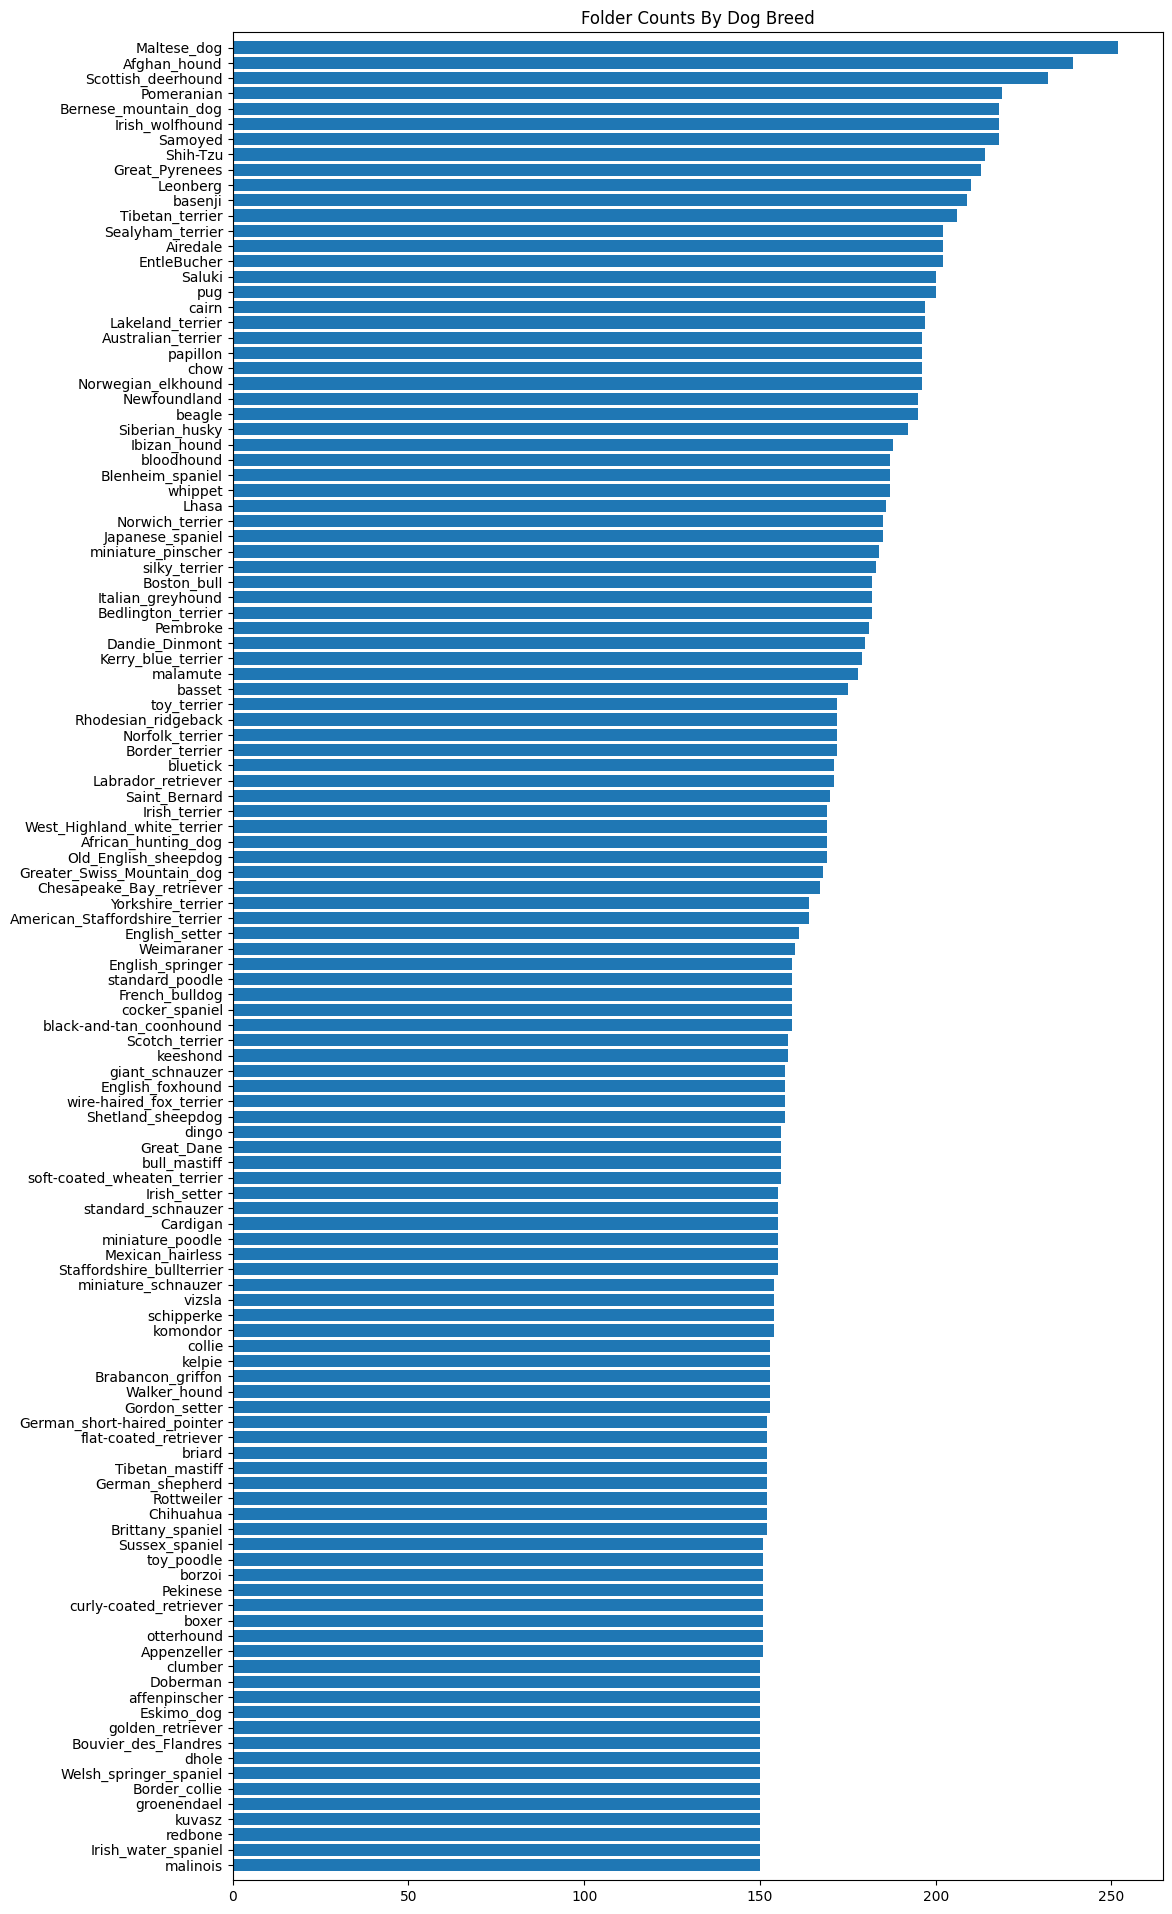

In [151]:
plot_folder_counts(dog_folder_counts_df)

In [93]:
dog_folder_counts_df.describe()

,len_files
count,120.000000
mean,171.525000
std,23.183217
min,150.000000
25%,152.750000
50%,159.500000
75%,186.250000
max,252.000000


In [94]:
# Lets balance the classes

In [95]:
# dst_path = r'C:\Users\Lindsay\DSND_Capstone\data\stanford\Images'
# for row in dog_folder_counts_df.itertuples():
#     for folder in ['train', 'test', 'valid']:
#         path = os.path.join(dst_path, folder, row.folder_name)
#         os.mkdir(path)

In [96]:
# src_path = 'D:\large_files\DSND_Capstone\data\stanford\Images'
# dst_path = r'C:\Users\Lindsay\DSND_Capstone\data\stanford\Images'
# copied = []
# not_copied = []

# for row in dog_folder_counts_df.itertuples():
    
#     path = os.path.join(src_path, row.folder_name)
    
#     # Get the files from the current folder
#     files = glob(path + r'/*')
    
#     for src in files[:150]:

#         # Create destination string (train, test, validation) based on a random draw (80, 10, 10)
#         num = random.randint(0, 9)
        
#         # Need to construct the path. So, need to get the last actual file_name from src
#         file_name = src.split('\\')[-1]
        
#         if num == 0:
#             dst = os.path.join(dst_path, 'test', row.folder_name, file_name)
#         elif num == 1:
#             dst = os.path.join(dst_path, 'valid', row.folder_name, file_name)
#         else:
#             dst = os.path.join(dst_path, 'train', row.folder_name, file_name)

#         try:
#             copyfile(src, dst)
#             copied.append([('src', src), ('dst', dst)])

#         except:
#             print('This file did not get copied properly:', src)
#             not_copied.append([('src', src), ('dst', dst)])
        
# print('length of copied files is:', len(copied))
# print('length of not_copied files is:', len(not_copied))

In [97]:
# Setup the path and the seperator
path = r'C:\Users\Lindsay\DSND_Capstone\data\stanford\Images\train'
sep = '-'

# Call the function to count the files
dog_folder_counts_df = count_files_in_folders(path, sep)
dog_folder_counts_df.head()

,folder_name,folder_number,breed,len_files
71,n02104029-kuvasz,n02104029,kuvasz,110
102,n02110958-pug,n02110958,pug,110
65,n02101556-clumber,n02101556,clumber,110
34,n02094114-Norfolk_terrier,n02094114,Norfolk_terrier,111
100,n02110627-affenpinscher,n02110627,affenpinscher,112


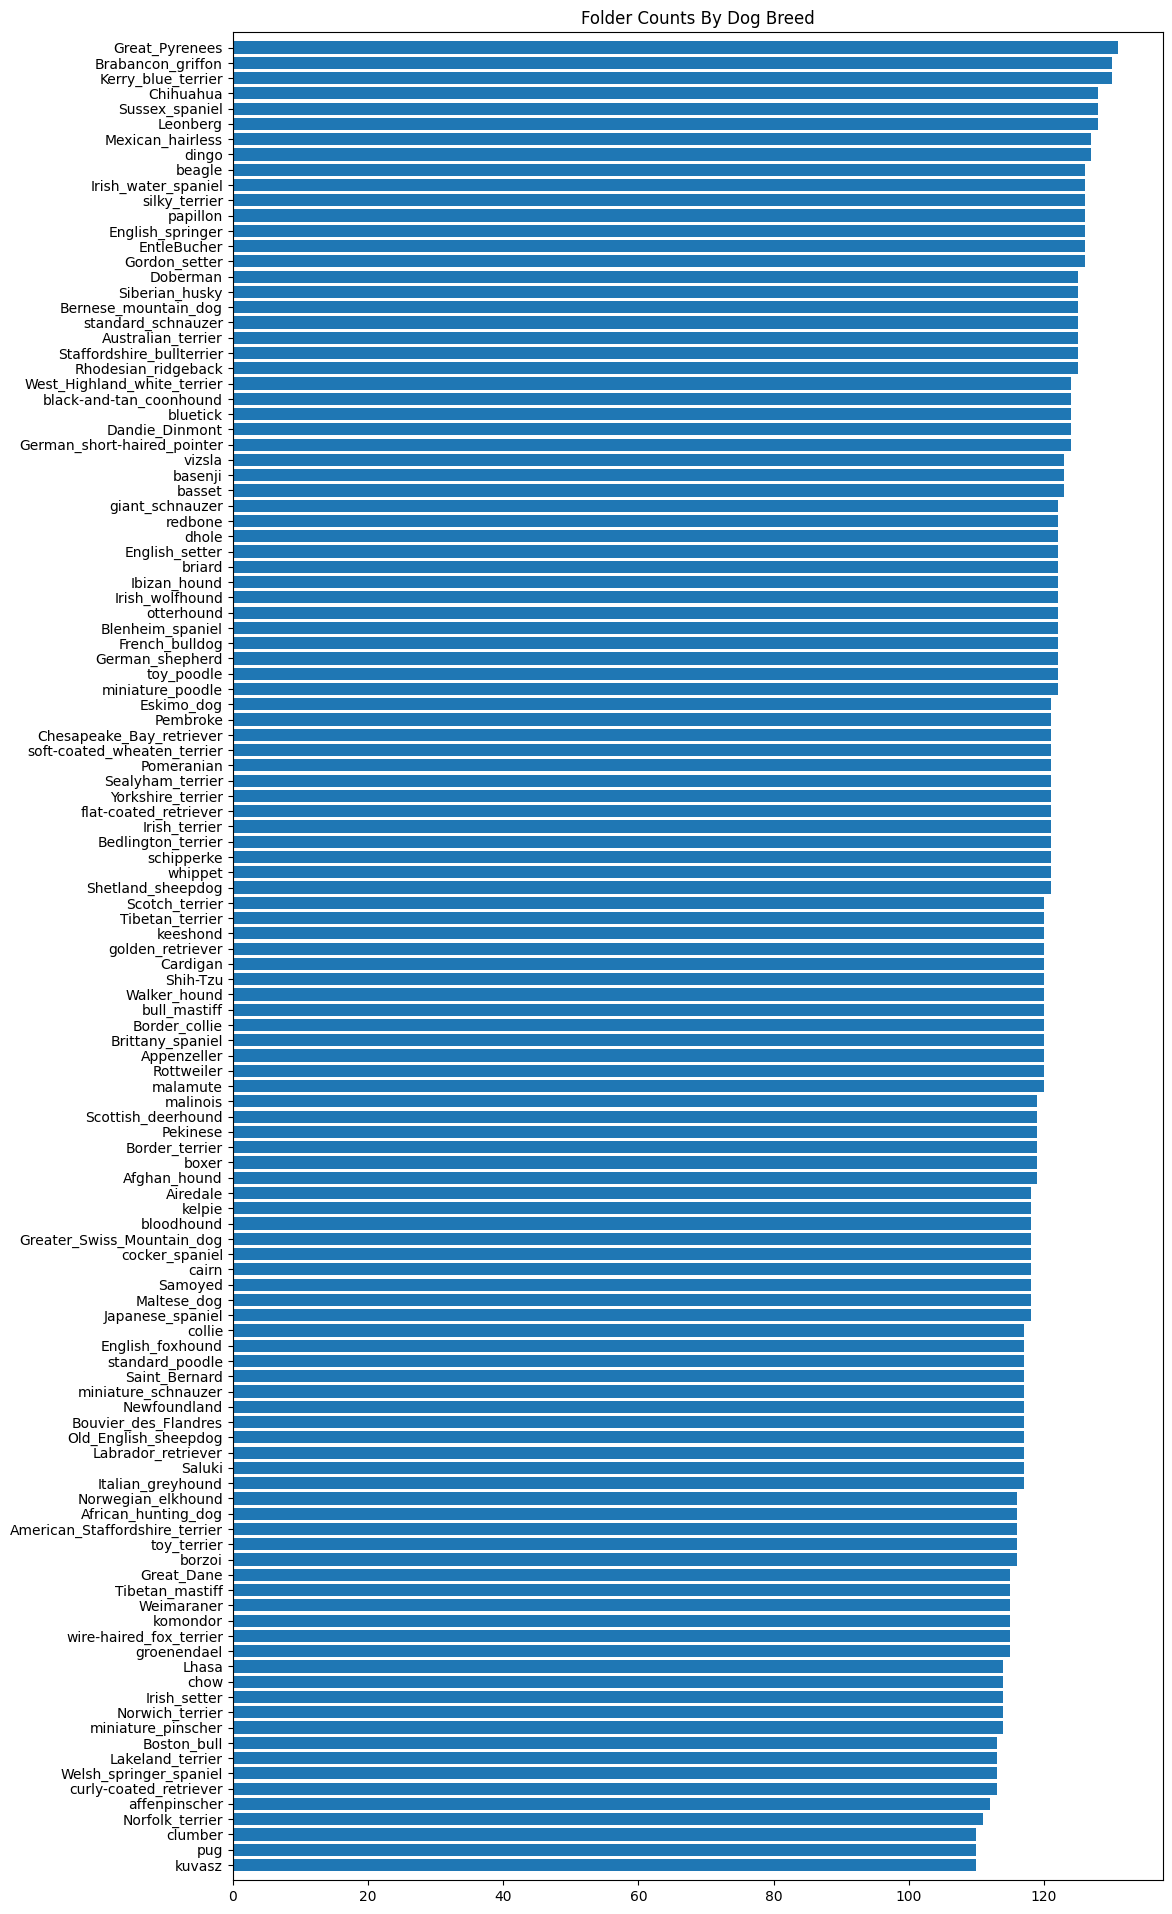

In [98]:
plot_folder_counts(dog_folder_counts_df)

Much better. The minimum is 109 and the maximum is 131 with a mean and median of 120. The other dataset had considerably more variance in terms of number of images in each class. This creates a situation (The non Stanford dataset) where the classifier can start cheating. For NOW, lets stick with the original provided database and see how I do. Just run the cell below for future use.

In [99]:
# define function to load train, test, and validation datasets
def load_dataset(path, nof_classes):
    
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), nof_classes)
    
    return dog_files, dog_targets


In [100]:
# load train, test, and validation datasets
path_st_dogs = r'C:\Users\Lindsay\DSND_Capstone\data\stanford\Images'
train_st_files, train_st_targets = load_dataset(path_st_dogs + r'\train', 120)
valid_st_files, valid_st_targets = load_dataset(path_st_dogs + r'\valid', 120)
test_st_files, test_st_targets = load_dataset(path_st_dogs + r'\test', 120)

# load list of dog names
dog_st_names = [item[20:-1] for item in sorted(glob(path_st_dogs + r"/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_st_names))
print('There are %s total dog images.\n' % len(np.hstack([train_st_files, valid_st_files, test_st_files])))
print('There are %d training dog images.' % len(train_st_files))
print('There are %d validation dog images.' % len(valid_st_files))
print('There are %d test dog images.'% len(test_st_files))

There are 120 total dog categories.
There are 18000 total dog images.

There are 14402 training dog images.
There are 1830 validation dog images.
There are 1768 test dog images.


In [101]:
# Put the working directory back to the home directory
os.chdir(r'D:\OneDrive\Data Science\udacity\dsnd\P5 - Capstone')
os.listdir()

['.gitignore',
 '.ipynb_checkpoints',
 'bottleneck_features',
 'CODEOWNERS',
 'data',
 'dog_app.ipynb',
 'dog_app_pipeline.ipynb',
 'extract_bottleneck_features.py',
 'haarcascades',
 'images',
 'iv3_stanford.ipynb',
 'LICENSE.txt',
 'model_rel_perf.csv',
 'ReadMe.ipynb',
 'requirements',
 'saved_models',
 '__pycache__']

### Image Variability Analysis

I want to see how much our images vary in terms of sizes (height and width). This variability will impact our pre processing decisions. All images have to be the same size. Lots of variability means that I may have some images that do not work well in terms of training the classifier.

In [102]:
def sample_images(input_file, idx, sep):
    """Load an image using keras load_img"""
    
    path = input_file[idx]
    img = load_img(path)
    
    breed = path.split(sep, 1)[1]
    
    return img, breed


jpg


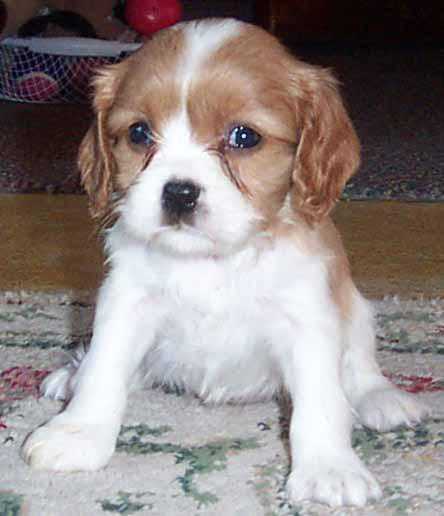

In [103]:
# Run this cell a few times to see the variation in the images
idx = randint(0, train_st_files.shape[0])
img, path = sample_images(train_st_files, idx, '.')
print(path)
img

In [104]:
# get height and width of each dog picture
height, width, path = [], [], []
for idx in range(len(train_st_files)):
    img = cv2.imread(train_st_files[idx])
    path.append(train_st_files[idx])
    height.append(img.shape[0])
    width.append(img.shape[1])

In [105]:
# Create a df to get some statistics
height_width_df = pd.DataFrame({'height': height,
                                'width': width,
                                'path': path})
display(height_width_df.head())
height_width_df.describe([.05, .1, .25, .5, .75, .95])

,height,width,path
0,338,500,C:\Users\Lindsay\DSND_Capstone\data\stanford\I...
1,317,300,C:\Users\Lindsay\DSND_Capstone\data\stanford\I...
2,500,470,C:\Users\Lindsay\DSND_Capstone\data\stanford\I...
3,500,388,C:\Users\Lindsay\DSND_Capstone\data\stanford\I...
4,336,448,C:\Users\Lindsay\DSND_Capstone\data\stanford\I...


,height,width
count,14402.000000,14402.000000
mean,384.532009,440.902166
std,126.846295,143.947792
min,103.000000,107.000000
5%,206.050000,218.050000
10%,252.000000,280.000000
25%,333.000000,360.000000
50%,375.000000,500.000000
75%,450.000000,500.000000
95%,500.000000,500.000000


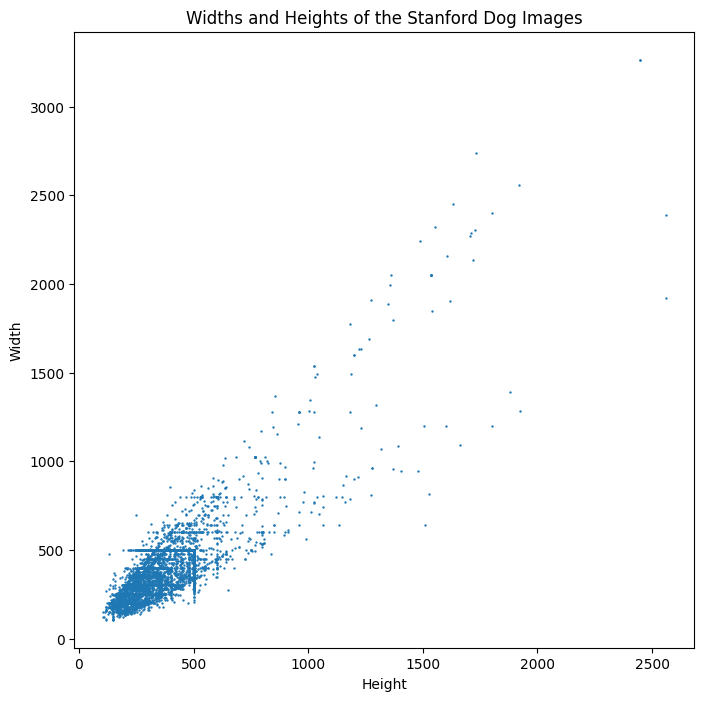

In [106]:
# Visualize the sizes via a scatter plot
plt.figure(figsize = (8,8))
plt.xlabel('Height')
plt.ylabel('Width')
plt.title('Widths and Heights of the Stanford Dog Images')
plt.scatter(height, width, s = .5)
plt.show();

It looks like quite a large number are fairly square. This is good!

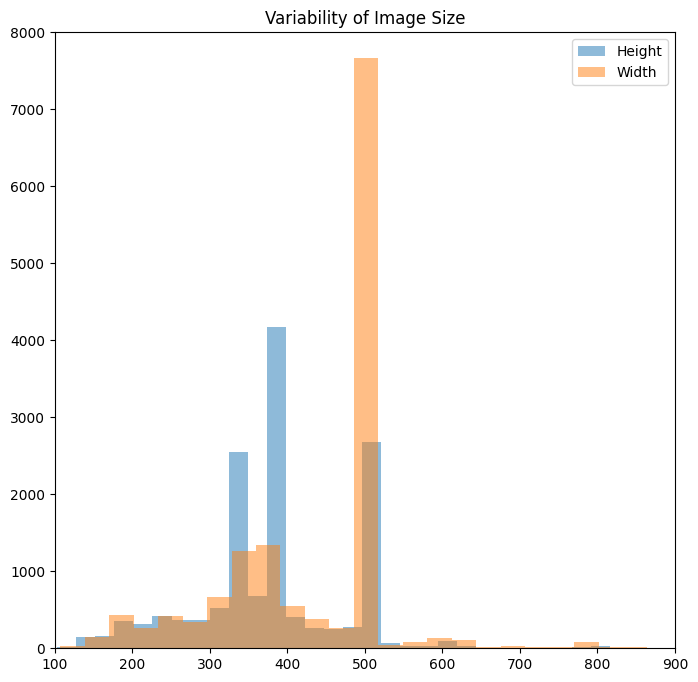

In [107]:
plt.figure(figsize = (8,8))
plt.hist(height, bins = 100, alpha=0.5)
plt.hist(width, bins = 100, alpha=0.5)
plt.axis([100, 900, 0, 8000])
plt.title('Variability of Image Size')
plt.legend(['Height', 'Width'])
plt.savefig(r'images\variability.png', dpi=300, bbox_inches='tight')
plt.show()

There is a LOT of variability in these sizes in this dataset!

### Histograms

Histogram equalization helps the CNN provide better accuracy since histogram equalization will increase the contrast level of the image. Due to this contrast stretching, the image will show artifacts and other useful features more prominently. You should get a better training result with histogram equalization. Lets look at some of the images and the histograms that they have.

In [108]:
def histogram_plot(idx):
    
    # Get image
    full_image = cv2.imread(train_st_files[idx])
    img = cv2.imread(train_st_files[idx], 0)
    
    # Caclulate histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist, bins = np.histogram(img.ravel(), 256, [0, 256])
    
    # Plot both images (histogram and picture)
    plt.subplot(121)
    plt.hist(img.ravel(), 256, [0, 256])
    plt.subplot(122)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.show()
    

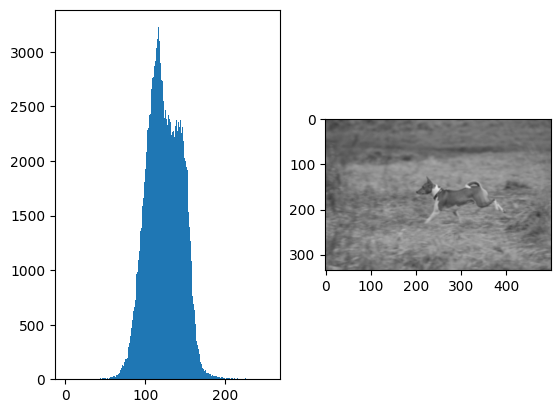

In [109]:
# Run this cell a few times to see the variation in the images
idx = randint(0, train_st_files.shape[0])
histogram_plot(idx)

What you want to see is a nice gaussian histogram. Some are very far away from that. 

### Establish Directory Structure For Input Files

In [110]:
# dataset paths
train_path = r'C:\Users\Lindsay\DSND_Capstone\data\stanford\Images\train'
test_path = r'C:\Users\Lindsay\DSND_Capstone\data\stanford\Images\test'

In [111]:
# Get the files from the n02085620-Chihuahua folder in test
files = glob(test_path + r'\n02085620-Chihuahua\*')
len(files)

9

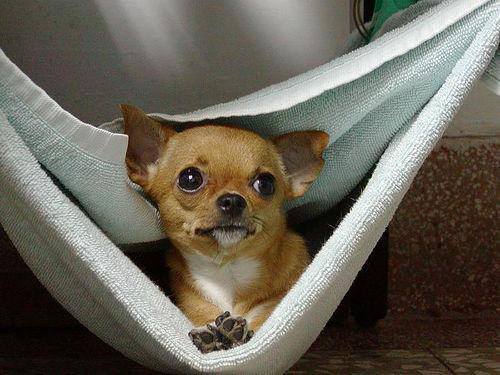

In [112]:
# Look at the 5th image in test in the n02085620-Chihuahua folder
files = glob(test_path + r'\n02085620-Chihuahua\*')

# See a sample image
display(Image.open(files[6]))

## Create Data Generators

In [128]:
# Create the train generator
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

In [129]:
# create the test generator
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

In [130]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical')

Found 14402 images belonging to 120 classes.


In [131]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1768 images belonging to 120 classes.


## Create The IV3 Model

In [132]:
# Instantiate iv3
model = InceptionV3(input_shape = [224, 224, 3], 
            weights = 'imagenet', 
            include_top = False)

In [133]:
# Look at the input tensor
model.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [134]:
# Tell iv3 that the LAST 16 layers ARE adjustable.
for layer in model.layers[:-16]:
  layer.trainable = False

In [135]:
# Get the number of folders which is the same as the number of labels
folders = glob(r'C:\Users\Lindsay\DSND_Capstone\data\stanford\Images\train\*')
n_classes = len(folders)
n_classes

120

In [136]:
# Create a new 'top' of the model (i.e. fully-connected layers).
# This is 'bootstrapping' a new top_model onto the pretrained layers.
top_model = model.output
top_model = GlobalAveragePooling2D(input_shape=(5, 5, 2048))(top_model)
top_model = Dropout(0.5)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)

In [137]:
# Group the convolutional base and new fully-connected layers into a Model object.
iv3_trainable_model = Model(inputs=model.input, outputs=output_layer)
iv3_trainable_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

## Fit the Model

In [138]:
# set hyperparameters
iv3_trainable_model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [139]:
checkpoint = ModelCheckpoint(filepath = 'saved_models/iv3_generators.h5', 
                             verbose = 2, 
                             save_best_only = True)

callbacks = [checkpoint]

start = datetime.now()

model_history = iv3_trainable_model.fit(
    train_set,
    validation_data = test_set,
    epochs = 7,
    steps_per_epoch = 256,
    validation_steps = 32,
    callbacks = callbacks,
    verbose = 1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/7
256/256 [==============================] - 151s 567ms/step - loss: 2.0806 - accuracy: 0.5093 - val_loss: 1.1482 - val_accuracy: 0.6768

Epoch 00001: val_loss improved from inf to 1.14823, saving model to saved_models\iv3_generators.h5
Epoch 2/7
256/256 [==============================] - 142s 552ms/step - loss: 1.2579 - accuracy: 0.6465 - val_loss: 1.0902 - val_accuracy: 0.6924

Epoch 00002: val_loss improved from 1.14823 to 1.09023, saving model to saved_models\iv3_generators.h5
Epoch 3/7
256/256 [==============================] - 139s 544ms/step - loss: 1.1943 - accuracy: 0.6666 - val_loss: 1.1089 - val_accuracy: 0.7129

Epoch 00003: val_loss did not improve from 1.09023
Epoch 4/7
256/256 [==============================] - 139s 544ms/step - loss: 1.1418 - accuracy: 0.6832 - val_loss: 1.0577 - val_accuracy: 0.7031

Epoch 00004: val_loss improved from 1.09023 to 1.05775, saving model to saved_models\iv3_generators.h5
Epoch 5/7
256/256 [==============================] - 140s 54

## Plot Training & Test Scores

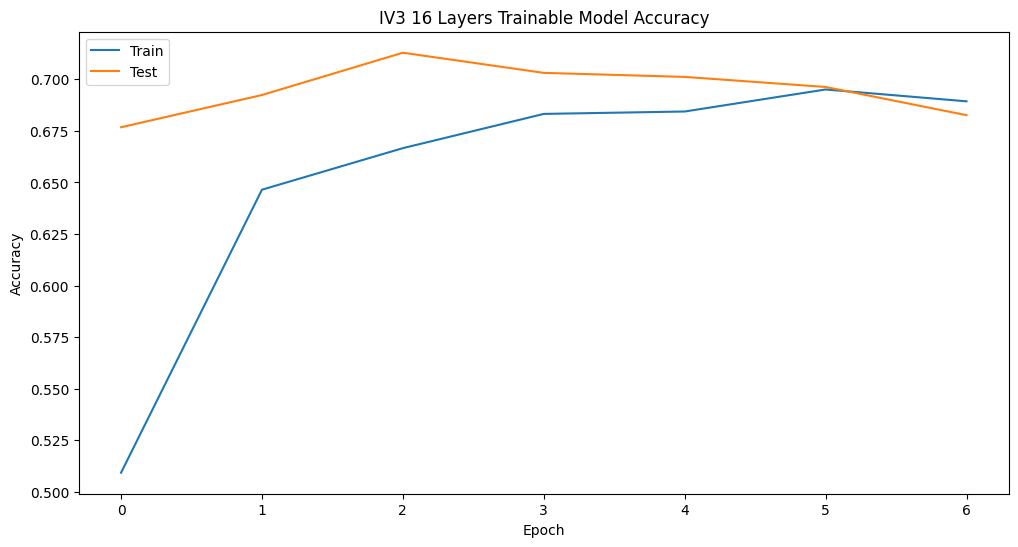

In [142]:
plt.figure(figsize = (12,6))
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('IV3 16 Layers Trainable Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

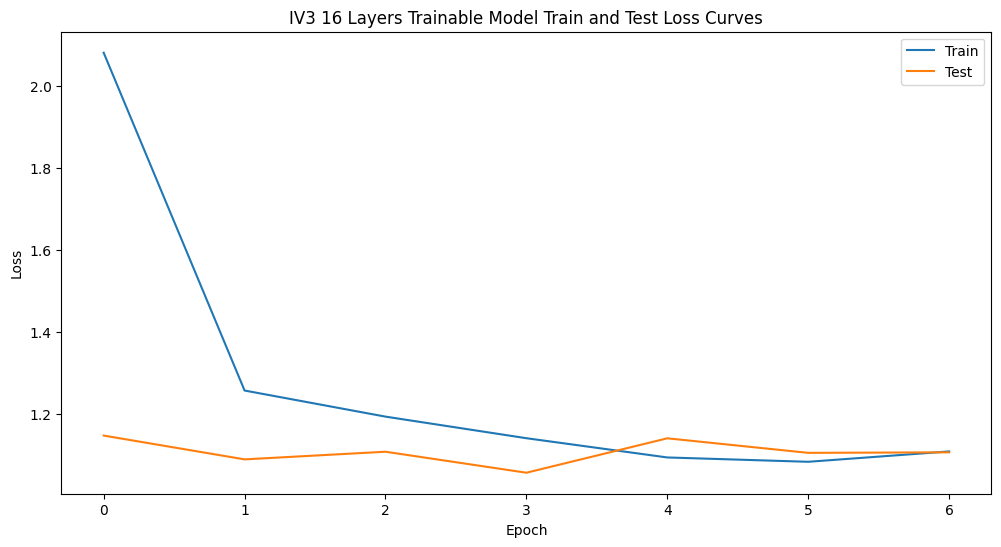

In [143]:
# This is for IV3 (Inception) loss
plt.figure(figsize = (12,6))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('IV3 16 Layers Trainable Model Train and Test Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

## Conclusions

The model works OK BUT not as well as the very simple IV3 model that we trained on the original dataset. 